# 1. 导入包

In [1]:
import numpy as np  
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
import gc

from pandas.core.frame import DataFrame
from scipy.fftpack import fft,ifft
from tqdm import tqdm
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.ticker import Locator
from matplotlib.ticker import MaxNLocator

# 2. 加载数据文件

In [2]:
dataset_name = "Printer"
csv_filename = "Printer.csv"
csv_featured_filename = "printer_featured_pca.csv"
df = pd.read_csv(csv_featured_filename
                 #, names=["time", "us", "acc","ws","label"]
                )
df.head(5)

,time,us,acc,avg_1,std_1,max_1,min_1,med_1,iqr_1,mcr_1,...,krt_8,fskw_8,fkrt_8,fmax_8,fspp_8,fetp_8,fctd_8,pca0,pca1,pca2
0,15:52:08.395,1012464,35.98,35.98,0.000000,35.98,35.98,35.980,0.00,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-532.339041,-214.743826,92.691824
1,15:52:08.433,1044468,33.42,34.70,1.280000,35.98,33.42,34.700,2.56,0.500000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-692.895763,-276.070715,117.397385
2,15:52:08.433,1076472,38.21,35.87,1.957056,38.21,33.42,35.980,4.79,0.666667,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-538.888225,-216.572312,93.119021
3,15:52:08.471,1108476,37.03,36.16,1.767725,38.21,33.42,36.505,1.05,0.250000,...,0.824385,0.0,0.0,0.0,0.0,0.0,0.0,-502.400996,-202.636911,87.510401
4,15:52:08.508,1140476,38.31,36.59,1.799856,38.31,33.42,37.030,2.23,0.200000,...,0.903630,0.0,0.0,0.0,0.0,0.0,0.0,-445.502007,-180.754675,78.616354


# 3. 预处理数据

In [3]:
acc_list = np.array(df["acc"])
acc_time = np.array(df["time"])
acc_us = np.array(df["us"])
acc_avg = np.array(df["avg_1"])
acc_std_list = np.array(df["std_1"])
acc_pca0_list = np.array(df["pca0"])
acc_pca1_list = np.array(df["pca1"])

acc_ms = [int(ms) for ms in acc_us/1000]
acc_mean = np.mean(acc_list)
acc_std  = np.std(acc_list)
acc_mean_str = "{:.2f}".format(acc_mean)
acc_std_str = "{:.2f}".format(acc_std)
print("the acc dist mean:%.2fmg and std:%.2fmg" %(acc_mean,acc_std))

the acc dist mean:37.96mg and std:11.93mg


# 4. 加速度传感器矫正

In [4]:
# 加速度传感器校准用
CONST_STATIC_WINDOW = 64
static_mean_list = []
static_std_list  = []
#遍历加速度，寻找传感器安静的时间段，记录它的avg和std
for k in tqdm(range(CONST_STATIC_WINDOW,acc_list.size,1)):
    acc_list_slice = acc_list[k-CONST_STATIC_WINDOW:k]
    acc_mean = np.mean(acc_list_slice)
    acc_std  = np.std(acc_list_slice)
    if acc_std < 5:
        static_std_list.append(acc_std)
        static_mean_list.append(acc_mean)

100%|██████████| 7164/7164 [00:00<00:00, 39763.64it/s]


# 5. 绘制加速度传感器在静止时候的均值-标准差分布

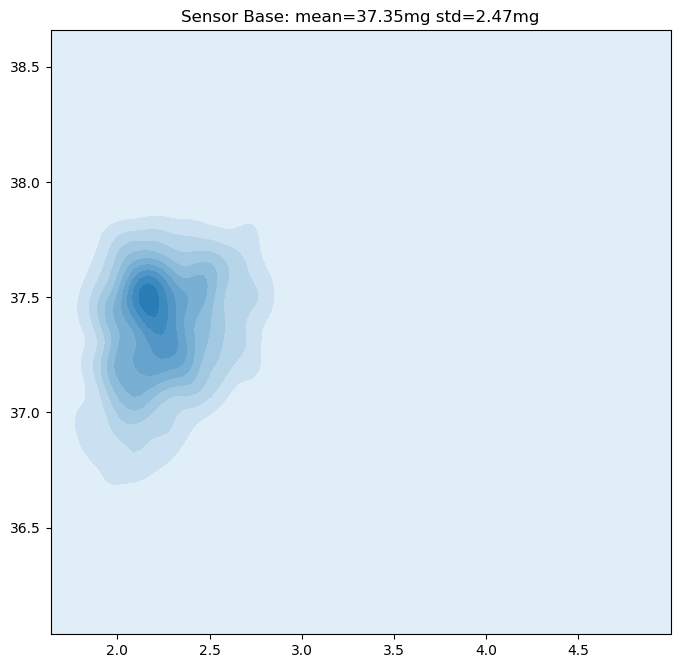

In [5]:
static_mean = np.mean(static_mean_list)
static_std = np.mean(static_std_list)
static_mean_str = "{:.2f}".format(static_mean)
static_std_str = "{:.2f}".format(static_std)
#print(static_std_list)
bins=np.arange(np.min(static_std_list),np.max(static_std_list),0.1)
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot()
ax.set_xlim(np.min(static_std_list), np.max(static_std_list))
sns.kdeplot(static_std_list,static_mean_list,shade=True)
plt.title("Sensor Base: mean="+static_mean_str+"mg std="+static_std_str+"mg")
plt.savefig(dataset_name+"_static.png")

# 6. 矫正加速度列表

In [6]:
acc_list = acc_list - static_mean # 将加速度列表矫正到0
acc_avg = acc_avg - static_mean

# 7. 以秒为单位计算std和avg，找出最大的以判断时域波形刻度范围

100%|██████████| 225/225 [00:00<00:00, 22480.19it/s]


13.564525155684148 [ 12.52746633 -12.23253367   4.91746633  23.51746633  -3.20253367
   7.78746633  26.43746633  -5.92253367 -17.59253367 -36.85253367
 376.13746633 -57.00253367 116.64746633 -98.64253367 162.69746633
 -74.00253367  71.94746633 -42.29253367  38.88746633 -39.27253367
  31.02746633 -31.75253367  13.08746633 -19.63253367  29.14746633
 -15.98253367  15.80746633  -1.93253367  12.18746633  -8.99253367
  -1.15253367  -8.27253367   0.49746633  -7.33253367]


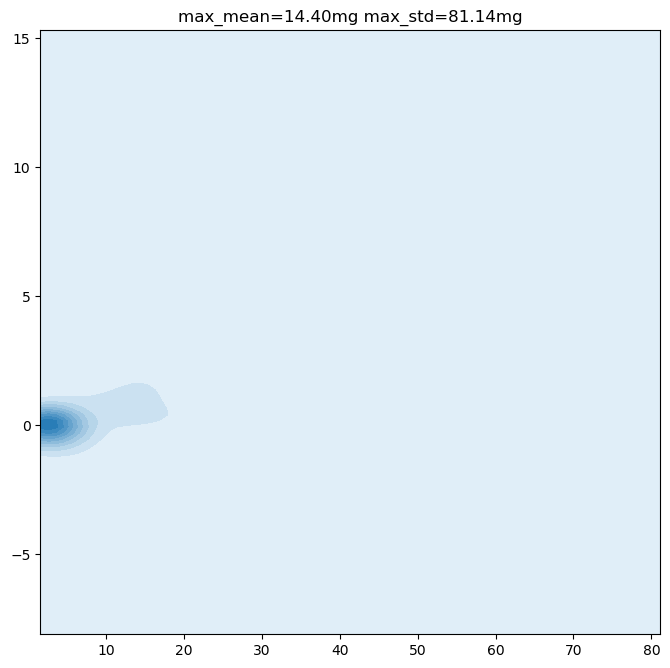

In [7]:
SECOND_WINDOW = 32# sample rate 32
second_mean_list = []
second_std_list  = []
acc_mean_max = float(0)
acc_std_max = float(0)
#遍历加速度，寻找传感器安静的时间段，记录它的avg和std
for k in tqdm(range(SECOND_WINDOW,acc_list.size,SECOND_WINDOW)):
    acc_list_slice = acc_list[k-SECOND_WINDOW:k]
    acc_mean_max = acc_mean_max if(acc_mean_max>np.mean(acc_list_slice)) else np.mean(acc_list_slice)
    if acc_mean_max>10000:
        print(acc_mean_max,k)
    acc_std_max  = acc_std_max if(acc_std_max>np.std(acc_list_slice)) else np.std(acc_list_slice)
    second_mean_list.append(np.mean(acc_list_slice))
    second_std_list.append(np.std(acc_list_slice))
print(np.mean(acc_list[5342:5376]),acc_list[5342:5376])
acc_mean_str = "{:.2f}".format(acc_mean_max)
acc_std_str = "{:.2f}".format(acc_std_max)
# print(static_std_list)
bins=np.arange(np.min(second_std_list),np.max(second_std_list),0.1)
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot()
ax.set_xlim(np.min(second_std_list), np.max(second_std_list))
sns.kdeplot(second_std_list,second_mean_list,shade=True)
plt.title("max_mean="+acc_mean_str+"mg max_std="+acc_std_str+"mg")
plt.savefig(dataset_name+"_dist_std_and_mean.png")

# 8. 以1024个点为单位遍历一次，找FFT的直流分量大小

In [8]:
FFT = list()
for i in range(0,len(acc_list)):
#     if FFT_0<np.mean(acc_list[i:i+32]):
    FFT.append(np.mean(acc_list[i:i+1024]))
#     print(np.mean(acc_list[i:i+32]),i)
np.mean(FFT)

0.6045913514913049

# 9. 开始画图

In [9]:
fig= Figure(figsize=[25.6,14.4],dpi=100,facecolor="black",edgecolor="#BEBEBE")
canvas = FigureCanvas(fig)
ax_chart_32s = fig.add_axes([100/2560,1100/1440,1278/2560,300/1440])
ax_chart_1s = fig.add_axes([1518/2560,1100/1440,372/2560,300/1440])

ax_violin = fig.add_axes([1518/2560,750/1440,372/2560,300/1440])
ax_violins = fig.add_axes([100/2560,750/1440,1378/2560,300/1440])

ax_spectrogram_32s = fig.add_axes([100/2560,50/1440,1378/2560,300/1440])
ax_spectrogram_4s = fig.add_axes([1518/2560,50/1440,372/2560,300/1440])

ax_FFT_32s = fig.add_axes([100/2560,400/1440,1378/2560,300/1440])
ax_FFT_4s = fig.add_axes([1518/2560,400/1440,372/2560,300/1440])

ax_kde_1 = fig.add_axes([1940/2560,50/1440,560/2560,300/1440])
# ax_kde_2 = fig.add_axes([2196/2560,50/1440,314/2560,314/1440])

ax_video = fig.add_axes([1940/2560,400/1440,560/2560,994/1440])#[x,y,width,height] y in range of 456 and 496
canvas.print_figure("123.png")
fig.savefig("sample.png",facecolor=fig.get_facecolor(),edgecolor=fig.get_edgecolor())

In [10]:
CONST_ACC_MAX = math.pow(2, int(math.log(acc_mean_max + 4 * acc_std_max, 2)) + 1)
CONST_ACC_MAX

512.0

# 使用seaborn画violin

In [11]:

def whiten(ax, title):
    spine = ['bottom', 'top', 'right', 'left']
    for tickline in ax.xaxis.get_ticklines():
        tickline.set_color('white')
    for ticklabel in ax.xaxis.get_ticklabels():
        ticklabel.set_color('white')
    for tickline in ax.yaxis.get_ticklines():
        tickline.set_color('white')
    for ticklabel in ax.yaxis.get_ticklabels():
        ticklabel.set_color('white')
    for orien in spine:
        ax.spines[orien].set_color('black')
    ax.set_facecolor("black")  # grey
    title.set_color("white")
    title.set_fontsize('large')


def whiten_violin(result):
    for key in result:
        if key is not 'bodies':
            result[key].set_color('')
            
def violins_color_decide(color_relative):
    if color_relative<2:
        return [1,0,0]#red
    elif color_relative<4:
        return [255/255,128/255,0/255]#orange
    elif color_relative<8:
        return [255/255,255/255,0/255]#yellow
    elif color_relative<16:
        return [255/255,255/255,128/255]#light yellow
    elif color_relative<32:
        return [1,1,1]#WHITE
    elif color_relative<64:
        return [128/255,255/255,255/255]#light blue
    else:
        return [0,255/255,255/255]#plain blue

In [12]:
#plt.savefig("sample.png")
CONST_ACC_MAX = 128
# define the limits automatically
#设置时域图和violin的y坐标的上下限
CONST_ACC_MIN = -CONST_ACC_MAX
CONST_CHART_WINDOW = 1024
CONST_FFT_WINDOW = 1024
CONST_VIOLIN_WINDOW = 32
CONST_VIOLINS_WINDOW = 1024
CONST_VIOLINS_DIV = 32
CONST_SAMP_RATE = 32  # 采样率
CONST_COLOR_STD_LMT = 128
CONST_BLUE_RGB = [0, 0, 255]
CONST_WHITE_RGB = [255, 255, 255]
CONST_FFT_MIN = 0
CONST_FFT_MAX = 1
#可以从第几个帧开始绘制
CONST_MIN_K = 7100
CONST_MAX_K = 5000
#帧图片文件夹
CONST_FRAMES_DIR = "dir_frames_toilet"

            
for k in tqdm(range(CONST_MIN_K, acc_list.size)):  # start form 1024, shift 8 every time
#     if k==CONST_MAX_K:
#         break
    ax_violin.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)
    ax_violins.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)

    # 绘制时域32s图
    slice_start = k - CONST_FFT_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    avg_slice = acc_avg[slice_start:slice_end]
    std_slice = acc_std_list[slice_start:slice_end]
    
    if acc_slice.size<CONST_CHART_WINDOW:
        acc_slice = np.lib.pad(acc_slice, (CONST_CHART_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))
        avg_slice = np.lib.pad(avg_slice, (CONST_CHART_WINDOW - avg_slice.size, 0), 'constant', constant_values=(0, 0))
        std_slice = np.lib.pad(std_slice, (CONST_CHART_WINDOW - std_slice.size, 0), 'constant', constant_values=(0, 0))
    
    ax_chart_32s.plot(acc_slice, 'w',avg_slice,"y")  # '--w'
    ax_chart_32s.set_ylabel("avg and realtime",color = "w")
    ax_chart_32s.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)
    title = ax_chart_32s.set_title("Realtime chart,Time: " + str(acc_time[k]) + "  Reading: " + "{:.2f}".format(acc_list[k]) + "mg")
    whiten(ax_chart_32s, title)
    
    #32s时域图上加std，双坐标系
    ax_chart_32s_std = ax_chart_32s.twinx()
    ax_chart_32s_std.plot(std_slice,"g")
    ax_chart_32s_std.set_ylabel("std",color = "w")
    ax_chart_32s_std.set_ylim(-acc_std_max,acc_std_max)
    whiten(ax_chart_32s_std, title)

    #绘制时域1s
    acc_slice_1s = acc_slice[-32:]
    ax_chart_1s.plot(acc_slice_1s,'w')
    ax_chart_1s.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)
    title = ax_chart_1s.set_title("Last second")
    whiten(ax_chart_1s, title)
    
    # 绘制FFT图
    #########################################
    fft_abs = abs(fft(acc_slice))
    fft_norm = fft_abs / int(CONST_FFT_WINDOW)
    fft_half = fft_norm[:int(CONST_FFT_WINDOW / 2)]
    fft_DC_32s = fft_half[0]
    fft_half[0]=0

    ax_FFT_32s.bar(x=np.linspace(0, CONST_SAMP_RATE / 2, 513)[:-1],
                   height=fft_half,width=0.032,bottom=0,align="center",color="white")

    ax_FFT_32s.xaxis.set_major_locator(MaxNLocator(nbins=20, prune='lower'))
    title = ax_FFT_32s.set_title("FFT chart:0 - 16Hz, DC:"+"{:.2f}".format(fft_DC_32s)+"AC max:"+"{:.2f}".format(np.max(fft_half)))
    title = ax_FFT_32s.set_title("FFT chart:0 - 16Hz")
    whiten(ax_FFT_32s, title)
    ax_FFT_32s.set_ylim(CONST_FFT_MIN, CONST_FFT_MAX)
    ax_FFT_32s.set_xlim(0, 16)  # 0-4hz
    
    #4s fft
    fft_abs = abs(fft(acc_slice[-128:]))
    fft_norm = fft_abs / int(128)
    fft_half = fft_norm[:64]
    fft_DC_4s = fft_half[0]
    fft_half[0]=0
    
    ax_FFT_4s.bar(x=np.linspace(0, CONST_SAMP_RATE / 2, 65)[:-1], 
                   height=fft_half,width=0.15,bottom=0,align="center",color="white")
    ax_FFT_4s.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='lower'))
    title = ax_FFT_4s.set_title("FFT chart:0 - 16Hz, DC:"+"{:.2f}".format(fft_DC_4s)+"AC max:"+"{:.2f}".format(np.max(fft_half)))
    whiten(ax_FFT_4s, title)
    ax_FFT_4s.set_ylim(CONST_FFT_MIN, CONST_FFT_MAX)
    ax_FFT_4s.set_xlim(0, 16)  # 0-16hz

    # 绘制violin图
    ##########################################
    slice_start = k - CONST_VIOLIN_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    if acc_slice.size<CONST_CHART_WINDOW:
        acc_slice = np.lib.pad(acc_slice, (CONST_VIOLIN_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))
    
    acc_slice_dataset = pd.DataFrame(acc_slice)
    violin_mean = acc_slice_dataset[0].mean()
    violin_std = acc_slice_dataset[0].std()
    violin_mean_str = "{:.5f}".format(violin_mean)
    violin_std_str = "{:.5f}".format(violin_std)

    face_color = [(CONST_WHITE_RGB[i] - (CONST_WHITE_RGB[i] - CONST_BLUE_RGB[i]) * abs(violin_std / CONST_COLOR_STD_LMT)) / 255 for i in range(3)]
    for color in face_color:
        if color<0:
            color=0

    ###########seaborn violin#############
    violinplot_ax = sns.violinplot(x=acc_slice, color=face_color, ax=ax_violin, linewidth=0,orient="v")
    ax.grid(False)
    
    title = ax_violin.set_title("Realtime violin. Mean: " + violin_mean_str + "  Std: " + violin_std_str)
    ax_violin.yaxis.set_major_locator(MaxNLocator(nbins=16, prune='lower'))
    whiten(ax_violin, title)

    # 绘制violins图
    ################################
    slice_start = k - CONST_VIOLINS_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    if acc_slice.size<CONST_CHART_WINDOW:
        acc_slice = np.lib.pad(acc_slice, (CONST_VIOLINS_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))

    violins_dataset = pd.DataFrame([acc_slice[int(t - CONST_VIOLINS_DIV):int(t)] for t in list(np.linspace(0, 1024, CONST_VIOLINS_DIV + 1)[1:])])
    
    color_list = []
    for row in range(CONST_VIOLINS_DIV):
        violins_color = abs(violins_dataset.loc[row, :].std())
        violins_color_relative = violins_color / CONST_COLOR_STD_LMT
        if violins_color_relative>1:
            violins_color_relative=1
        color_list.append(violins_color_decide(violins_color_relative*128))
        # rgba in float 0-1 form
        
    violins_result = ax_violins.violinplot(dataset=violins_dataset)
    ax_violins.yaxis.set_major_locator(MaxNLocator(nbins=(CONST_ACC_MAX / 4) + 1, prune='lower'))
    
    for pc in range(len(violins_result['bodies'])):
        violins_result['bodies'][pc].set_facecolor(color_list[pc])
        violins_result['bodies'][pc].set_edgecolor(color_list[pc])
        violins_result['bodies'][pc].set_alpha(1.0)
    
    title = ax_violins.set_title("History violins")
    ax_violins.yaxis.set_major_locator(MaxNLocator(nbins=16, prune='lower'))
    whiten(ax_violins, title)
    whiten_violin(violins_result)
    
    #draw specgram
    ####################################
    #32s
    slice_start = k - CONST_FFT_WINDOW -128
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    if acc_slice.size<CONST_CHART_WINDOW:
        acc_slice = np.lib.pad(acc_slice, (CONST_FFT_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))

    spectrum_32s,freqs_32s,ts_32s,fi_32s=ax_spectrogram_32s.specgram(x = acc_slice,
                mode='magnitude',
                scale = "linear",
                NFFT=128,
                Fs=32, Fc=None,
                window=np.hanning(M = 128), 
                noverlap=127,
                sides="onesided",
                xextent=[0,32],
                vmax=CONST_FFT_MAX,
                vmin=0,
                cmap=plt.cm.gray
                )
    
    title = ax_spectrogram_32s.set_title("32s spectrogram")
    whiten(ax_spectrogram_32s,title)
    #4s
    spectrum_4s,freqs_4s,ts_4s,fi_4s=ax_spectrogram_4s.specgram(x = acc_slice[-256:],
            mode='magnitude',
            scale = "linear",#do not use db, or the graph would have a bunch of drak part                             
            NFFT=128,
            Fs=32, Fc=None,
            window=np.hanning(M = 128), 
            noverlap=127,
            sides="onesided",
            xextent=[0,4],
            vmax=CONST_FFT_MAX,
            vmin=0,
            cmap=plt.cm.gray
            )
#     mode : {'default', 'psd', 'magnitude', 'angle', 'phase'}
#     What sort of spectrum to use. Default is 'psd', which takes the power spectral density. PSD is the square of magnitude
#     'magnitude' returns the magnitude spectrum. 'angle' returns the phase spectrum without unwrapping. 
#     'phase' returns the phase spectrum with unwrapping.

#     scale : {'default', 'linear', 'dB'}
#     The scaling of the values in the spec. 'linear' is no scaling. 
#     'dB' returns the values in dB scale. When mode is 'psd', this is dB power (10 * log10).
#     Otherwise this is dB amplitude (20 * log10).
#     'default' is 'dB' if mode is 'psd' or 'magnitude' and 'linear' otherwise. This must be 'linear' if mode is 'angle' or 'phase'.


    title = ax_spectrogram_4s.set_title("4s spectrogram")
    whiten(ax_spectrogram_4s,title)
    
    #draw pca result
    ##################################################
    ax_kde_1.set_xlim(np.min(acc_pca0_list),np.max(acc_pca0_list))
    ax_kde_1.set_ylim(np.min(acc_pca1_list),np.max(acc_pca1_list))
    sns.kdeplot(acc_pca0_list[k-128:k],acc_pca1_list[k-128:k],shade=False,ax = ax_kde_1,cmap=plt.cm.gray)
    
    title = ax_kde_1.set_title("PCA KDE")
    whiten(ax_kde_1,title)
    
    # 调整 video框
    ax_video.set_facecolor("black")
    spine = ['bottom', 'top', 'right', 'left']
    for orien in spine:
        ax_video.spines[orien].set_color('white')
    ax_video.axis(option=False)

    # save figs
    fig.savefig("dir_frames_printer/" + str(10000000000 + acc_ms[k]) + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    ax_chart_32s.cla()
    ax_chart_32s_std.cla()
    ax_chart_1s.cla()
    ax_FFT_32s.cla()
    ax_FFT_4s.cla()
    ax_violin.cla()
    ax_violins.cla()
    ax_spectrogram_32s.cla()
    ax_spectrogram_4s.cla()
    del fi_32s #delete the fig instance, otherwise would slow down the process due to memory depletion
    gc.collect()

100%|██████████| 128/128 [04:41<00:00,  2.20s/it]


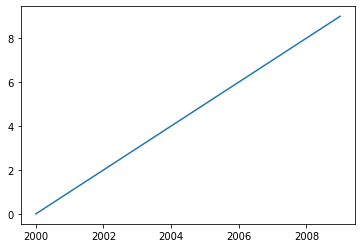

In [4]:
plt.plot(np.arange(2000, 2010), range(10))